# Preprocessing of Methylation Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn, h5py
%matplotlib inline

/home/sasse/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [50]:
LOAD_ANNOTATION_WITH_PROM = True
m_file = '/project/gcn/diseasegcn/data/pancancer/TCGA/methylation/download/ff41e5fe-2564-4f23-942b-60fbdd33b596/jhu-usc.edu_BRCA.HumanMethylation27.2.lvl-3.TCGA-BH-A0HW-01A-11D-A032-05.gdc_hg38.txt'
m_file2 = '/project/gcn/diseasegcn/data/pancancer/TCGA/methylation/download/fff8ff71-7c4d-4f25-a611-7843b8b84b45/jhu-usc.edu_LUAD.HumanMethylation450.2.lvl-3.TCGA-35-5375-01A-01D-1626-05.gdc_hg38.txt'

In [52]:
m_df_1 = pd.read_csv(m_file, sep='\t')
m_df_1.dropna(axis=0, inplace=True)
m_df_2 = pd.read_csv(m_file2, sep='\t')
m_df_2.dropna(axis=0, inplace=True)

In [41]:
if LOAD_ANNOTATION_WITH_PROM:
    anno_file = '/project/gcn/diseasegcn/data/pancancer/TCGA/methylation/annotation_with_promoters_500bp.tsv'
    a_df = pd.read_csv(anno_file, sep='\t')
else:
    anno_file = '/project/gcn/diseasegcn/data/pancancer/TCGA/methylation/gencode.v28.annotation.gff3'
    a_df = pd.read_csv(anno_file, sep='\t', skiprows=7, header=None, names=['chr', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attr'])
    a_df.dropna(axis=0, inplace=True)
    a_df = a_df[a_df.type == 'gene']
    annotated_gene_ids = [i[0].strip().split('=')[1].strip().split('.')[0].strip() for i in a_df.attr.str.split(';')]
    annotated_gene_names = [i[3].strip().split('=')[1].strip() for i in a_df.attr.str.split(';')]
    a_df['ID'] = annotated_gene_ids
    a_df['Symbol'] = annotated_gene_names
    a_df.drop_duplicates(subset='Symbol', inplace=True) # remove duplicate genes (not interested in transcript level)
a_df.head()

,Unnamed: 0,chr,source,type,start,end,score,strand,phase,attr,ID,Symbol,promoter_start,promoter_end
0,1062,chr1,HAVANA,gene,944204.0,959309.0,.,-,.,ID=ENSG00000188976.10;gene_id=ENSG00000188976....,ENSG00000188976,NOC2L,959059.0,959559.0
1,1144,chr1,HAVANA,gene,960587.0,965715.0,.,+,.,ID=ENSG00000187961.13;gene_id=ENSG00000187961....,ENSG00000187961,KLHL17,960337.0,960837.0
2,1375,chr1,HAVANA,gene,998962.0,1000172.0,.,-,.,ID=ENSG00000188290.10;gene_id=ENSG00000188290....,ENSG00000188290,HES4,999922.0,1000422.0
3,1414,chr1,HAVANA,gene,1001138.0,1014541.0,.,+,.,ID=ENSG00000187608.8;gene_id=ENSG00000187608.8...,ENSG00000187608,ISG15,1000888.0,1001388.0
4,1451,chr1,HAVANA,gene,1020123.0,1056118.0,.,+,.,ID=ENSG00000188157.14;gene_id=ENSG00000188157....,ENSG00000188157,AGRN,1019873.0,1020373.0


In [55]:
# load Container
data_file = '../../data/pancancer/hotnet_iref_vec_input_unbalanced.h5'

with h5py.File(data_file, 'r') as f:
    network = f['network'][:]
    features = f['features'][:]
    node_names = f['gene_names'][:]
    y_train = f['y_train'][:]
    y_test = f['y_test'][:]
    if 'y_val' in f:
        y_val = f['y_val'][:]
    else:
        y_val = None
    train_mask = f['mask_train'][:]
    test_mask = f['mask_test'][:]
    if 'mask_val' in f:
        val_mask = f['mask_val'][:]
    else:
        val_mask = None

# build data frame for node names
node_names_df = pd.DataFrame(node_names, columns=['ID', 'Symbol'])
print ("#genes in network but without annotation: {}".format(node_names_df[~node_names_df.Symbol.isin(a_df.Symbol)].shape[0]))

#genes in network but without annotation: 519


In [7]:
a_df = a_df[a_df.Symbol.isin(node_names_df.Symbol)]
print (a_df.shape)
a_df.drop_duplicates(subset='Symbol', inplace=True)

(11610, 11)


In [137]:
mean_meth = pd.read_csv('../../data/pancancer/TCGA/methylation/mean_450k_methylation_profile.tsv', sep='\t')

In [138]:
mean_meth.head()

,Unnamed: 0,Composite Element REF,Beta_value_sum,Chromosome,Start,End,Gene_Symbol,Gene_Type,Transcript_ID,Position_to_TSS,CGI_Coordinate,Feature_Type,Beta_value_mean
0,0,cg00000029,1305.707632,chr16,53434200,53434201,RBL2;RBL2;RBL2,protein_coding;protein_coding;protein_coding,ENST00000262133.9;ENST00000544405.5;ENST000005...,-221;-1420;222,CGI:chr16:53434489-53435297,N_Shore,0.286026
1,1,cg00000108,0.000000,chr3,37417715,37417716,C3orf35;C3orf35;C3orf35;C3orf35;C3orf35;C3orf3...,lincRNA;lincRNA;lincRNA;lincRNA;lincRNA;lincRN...,ENST00000328376.8;ENST00000332506.6;ENST000004...,18552;18552;6505;31445;18143;447;18552;18552,CGI:chr3:37451927-37453047,.,0.000000
2,2,cg00000109,0.000000,chr3,172198247,172198248,FNDC3B;FNDC3B;FNDC3B;FNDC3B;FNDC3B;FNDC3B,protein_coding;protein_coding;protein_coding;p...,ENST00000336824.7;ENST00000415807.5;ENST000004...,157692;158618;151333;71272;158587;71273,CGI:chr3:172039703-172040934,.,0.000000
3,3,cg00000165,1931.894856,chr1,90729117,90729118,.,.,.,.,CGI:chr1:90724932-90727247,S_Shore,0.423197
4,4,cg00000236,4043.750654,chr8,42405776,42405777,VDAC3,protein_coding,ENST00000022615.7,13872,CGI:chr8:42410918-42411241,.,0.885816


In [141]:
def promoter_window_wrapper(row):
    start, end = get_promotor_window(row['start'], row['end'], row['strand'], mean_meth)
    return start, end


def get_promotor_window(start, end, strand, meth_data=None):
    if strand == '+':
        tss = start
    else:
        tss = end
    if not meth_data is None: # fancy method to get promoter
        scan_region = (np.max(tss-1000, 0), tss + 1000)
        return calculate_promoter_window(scan_region[0], scan_region[1], meth_data)
    else:
        return np.max(tss-250, 0), tss + 250


def calculate_promoter_window(scan_start, scan_end, meth_data, shift=50, size=200):
    best_mean_meth = None
    best_window = (None, None)
    for i in range(int(scan_start), int(scan_end-size+1), shift):
        # get mean meth for window
        m_sites_window = meth_data[meth_data.Start.between(i, i+size)]
        m_mean_window = m_sites_window.Beta_value_mean.mean()
        
        # decide on best window
        if best_mean_meth is None: # first window
            best_mean_meth = m_mean_window
            best_window = i, i+size
        else: # any of the later windows
            if abs(best_mean_meth-m_mean_window) > 0.25: # large change in mean detected
                break
            else: # make the current window the best one
                best_mean_meth = m_mean_window
                best_window = i, i+size
    return best_window
promoter_vec = np.vectorize(get_promotor_window)

In [55]:
%load_ext line_profiler

In [142]:
x = a_df.apply(promoter_window_wrapper, axis=1)

In [143]:
p_starts = np.array([i[0] for i in x])
p_ends = np.array([i[1] for i in x])


(array([   0.,    0., 5325.,   66.,   73.,    0.,   81.,   94.,  114.,
         109.,    0.,  105.,   93.,  128.,  124.,  139.,    0.,  133.,
         133.,  153.,  157.,    0.,  144.,  138.,  153.,  139.,  154.,
           0.,  158.,  148.,  190.,  232.,    0.,  223.,  257.,  228.,
         266.,  252.,    0.,  239.,  218.,  226.,  277.,    0.,  262.,
         297.,  382.,    0.,    0.]),
 array([-1000.        ,  -959.18367347,  -918.36734694,  -877.55102041,
         -836.73469388,  -795.91836735,  -755.10204082,  -714.28571429,
         -673.46938776,  -632.65306122,  -591.83673469,  -551.02040816,
         -510.20408163,  -469.3877551 ,  -428.57142857,  -387.75510204,
         -346.93877551,  -306.12244898,  -265.30612245,  -224.48979592,
         -183.67346939,  -142.85714286,  -102.04081633,   -61.2244898 ,
          -20.40816327,    20.40816327,    61.2244898 ,   102.04081633,
          142.85714286,   183.67346939,   224.48979592,   265.30612245,
          306.12244898,   346.9

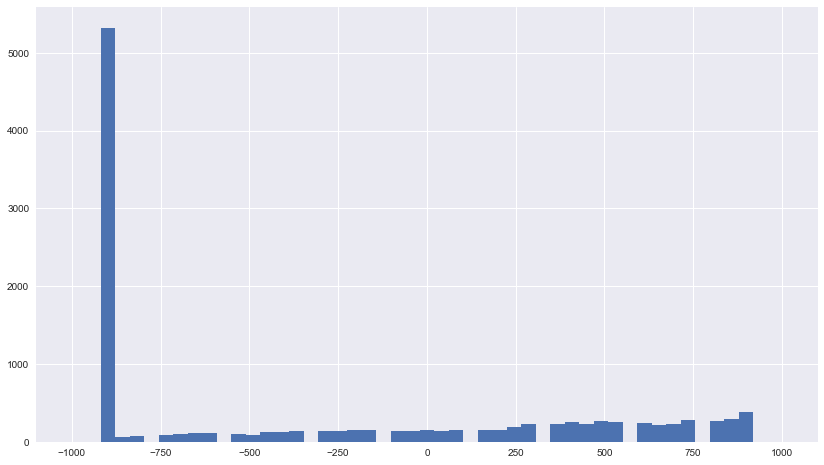

In [144]:
a_df['TSS'] = 0
a_df.loc[a_df.strand == '+', 'TSS'] = a_df[a_df.strand == '+'].start
a_df.loc[a_df.strand == '-', 'TSS'] = a_df[a_df.strand == '-'].end
d_to_prom = a_df.TSS - (p_ends+p_starts)/2
fig = plt.figure(figsize=(14, 8))
bins = np.linspace(-1000, 1000, 50)
plt.hist(d_to_prom, bins=bins)

In [145]:
a_df['promoter_start'] = p_starts
a_df['promoter_end'] = p_ends
a_df.to_csv('../../data/pancancer/TCGA/methylation/annotation_with_promoters.tsv', sep='\t')

In [42]:
def get_mean_betaval_for_promoters(annotation_genes, methylation_levels):
    """Extract the mean methylation level at promoters for each gene in the annotation.
    
    This function looks for all the methylation sites that fall
    inside all the promoters in the annotation genes df.
    The annotation_genes df is expected to contain the columns
    'promoter_start' and 'promoter_end'.
    
    Parameters:
    ----------
    annotation_genes:                 A dataframe containing a gene per row.
                                      It needs to have columns for promoter_start
                                      and promoter_end.
    methylation_levels:               A dataframe that contains cpg sites per row.
                                      The sites are expected to be one bp long and
                                      should have the columns: 'Start', 'End' and 
                                      'Beta_value'.
    Returns:
    Two lists with the mean beta values for each promoter and the number of cpg sites
    that support the promoter. The first list contains the mean beta values and
    the second list contains the support.
    """
    beta_vals_prom = []
    beta_vals_gene = []
    n_supports_prom = []
    n_supports_gene = []
    count = 0
    for _, row in annotation_genes.iterrows():
        # promoter
        m_sites_in_promoter = methylation_levels[methylation_levels.Start.between(row.promoter_start, row.promoter_end)]
        beta_vals_prom.append(m_sites_in_promoter.Beta_value.mean())
        n_supports_prom.append(m_sites_in_promoter.shape[0])
        # gene body
        if row.strand == '+':
            m_sites_gene = methylation_levels[methylation_levels.Start.between(row.promoter_end, row.end)]
        else:
            m_sites_gene = methylation_levels[methylation_levels.Start.between(row.start, row.promoter_start)]
        beta_vals_gene.append(m_sites_gene.Beta_value.mean())
        n_supports_gene.append(m_sites_gene.shape[0])
        if count % 1000 == 0:
            print (count)
        count += 1

    return beta_vals_prom, beta_vals_gene, n_supports_prom, n_supports_gene

In [79]:
def get_preprocessed_sample(a_df, m_df):
    beta_vals_p, beta_vals_g, n_supports_p, n_supports_g = get_mean_betaval_for_promoters(a_df, m_df)
    res = pd.DataFrame([beta_vals_p, n_supports_p, beta_vals_g, n_supports_g]).T
    res.columns = ['mean_beta_value_promoter', 'support_promoter',
                   'mean_beta_value_gene', 'support_gene']
    res.set_index(a_df.Symbol, inplace=True)
    return res

In [80]:
gene_names_df = node_names_df[node_names_df.Symbol.isin(a_df.Symbol)]
s1 = get_preprocessed_sample(a_df, m_df_1)
s2 = get_preprocessed_sample(a_df, m_df_2)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000


In [82]:
samples = [s1, s2]
total_df = pd.concat(samples, axis=1)
total_df.shape

(11610, 8)

In [83]:
total_df.head()

,mean_beta_value_promoter,support_promoter,mean_beta_value_gene,support_gene,mean_beta_value_promoter,support_promoter,mean_beta_value_gene,support_gene
Symbol,,,,,,,,
NOC2L,0.019981,1.0,0.434695,4.0,0.440941,5.0,0.654141,144.0
KLHL17,NaN,0.0,NaN,0.0,0.576905,5.0,0.755519,56.0
HES4,NaN,0.0,0.011724,1.0,0.632186,4.0,0.237125,7.0
ISG15,0.017603,1.0,0.017380,5.0,0.460140,9.0,0.609222,249.0
AGRN,NaN,0.0,0.163072,10.0,0.545893,12.0,0.661636,512.0


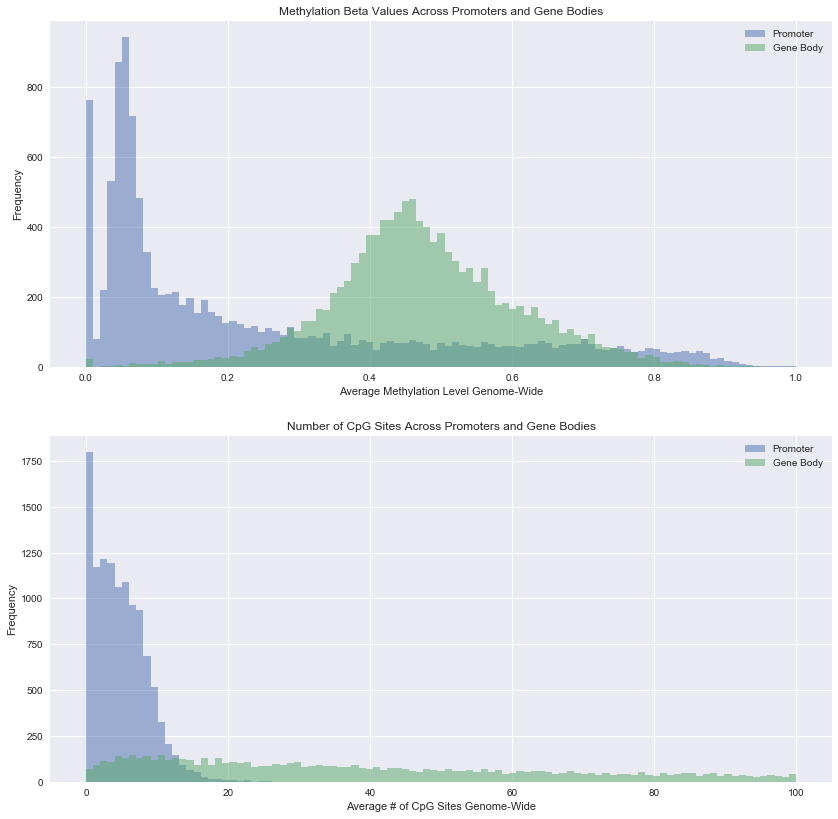

In [46]:
fig = plt.figure(figsize=(14, 14))
bins_beta = np.linspace(0, 1, 100)
bins_sup = np.linspace(0, 100, 100)
plt.subplot(2, 1, 1)
plt.hist(res.mean_beta_value_promoter.fillna(0), bins=bins_beta,
         label='Promoter', alpha=0.5)
plt.hist(res.mean_beta_value_gene.fillna(0), bins=bins_beta,
         label='Gene Body', alpha=0.5)
plt.xlabel('Average Methylation Level Genome-Wide')
plt.ylabel('Frequency')
plt.title('Methylation Beta Values Across Promoters and Gene Bodies')
plt.legend(loc='upper right')
plt.subplot(2, 1, 2)
plt.hist(res.support_promoter, label='Promoter', bins=bins_sup, alpha=0.5)
plt.hist(res.support_gene, label='Gene Body', bins=bins_sup, alpha=0.5)
plt.xlabel('Average # of CpG Sites Genome-Wide')
plt.ylabel('Frequency')
plt.title('Number of CpG Sites Across Promoters and Gene Bodies')
plt.legend(loc='upper right')
plt.savefig('beta_value_distribution_sample.png')

In [165]:
node_names_df.meth_beta.min()

0.0

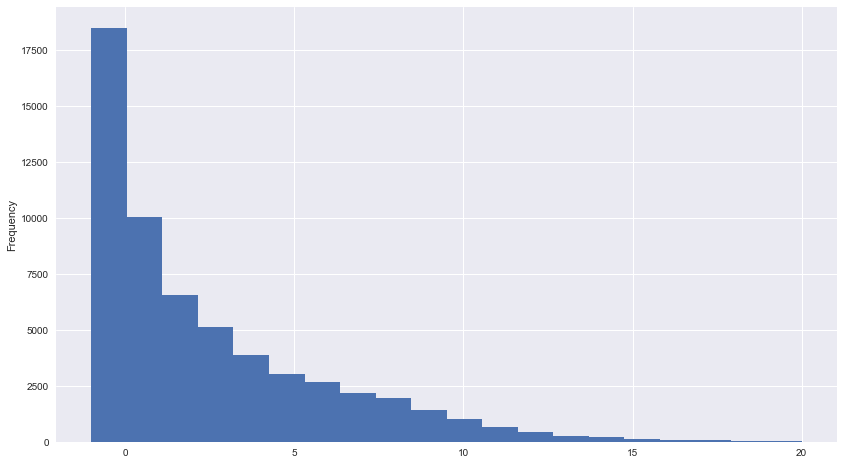

In [34]:
a_df.meth_support.plot(kind='hist', bins=np.linspace(-1, 20, 21), figsize=(14, 8))

In [35]:
a_df[a_df.meth_support <= 0].shape, a_df.beta_value.isnull().sum()

((18518, 13), 18518)

In [37]:
%%timeit
m_df[m_df.Start.between(a_df.iloc[0].promoter_start, a_df.iloc[0].promoter_end)]

1000 loops, best of 3: 1.63 ms per loop


In [73]:
sample_id = m_file.split('.')[-3].strip()
sample_id

'TCGA-BH-A0HW-01A-11D-A032-05'